In [13]:
import numpy as np

class PCA:
    def __init__(self, n_components):
        """初始化PCA"""
        assert n_components >= 1, "n_components must be valid"
        self.n_components = n_components
        self.components_ = None
        
    def fit(self, X, eta=0.01, n_iters=1e4):
        """获取数据集的前n个主成分"""
        assert self.n_components <= X.shape[1], "n_components must not be greater than the feature number of X"
        
        def demean(X):
            return X - np.mean(X, axis=0)
        
        def f(w, X):
            return np.sum((X.dot(w)**2)) / len(X)

        def df(w, X):
            return X.T.dot(X.dot(w)) * 2. / len(X)

        # 把向量单位化
        def direction(w):
            return w / np.linalg.norm(w)

        def first_component(X, initial_w, eta, n_iters=1e4, epsilon=1e-8):
            w = direction(initial_w)
            cur_iter = 0
            while cur_iter < n_iters:
                gradient = df(w, X)
                last_w = w
                w = w + eta * gradient
                w = direction(w)
                if(abs(f(w, X)) - abs(f(last_w, X)) < epsilon):
                   break
                cur_iter += 1
            return w

        X_pca = demean(X)
        self.components_ = np.empty(shape = (self.n_components, X.shape[1]))
        for i in range(self.n_components):
            initial_w = np.random.random(X.shape[1])
            eta = 0.001
            w = first_component(X_pca, initial_w, eta)
            self.components_[i, :] = w
            X_pca = X_pca - X_pca.dot(w).reshape(-1, 1) * w
        return self
    
    def transform(self, X):
        """将给定的X，映射到各个主成分分量中"""
        assert X.shape[1] == self.components_.shape[1]
        return X.dot(self.components_.T)
        
    def inverse_transform(self, X):
        """将给定的X反向映射回原来的特征空间"""
        assert X.shape[1] == self.components_.shape[0]
        return X.dot(self.components_)

    def __repr__(self):
        return "PCA(n_components=%d)" % self.n_components

### 从高维数据向低维数据映射

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
X = np.empty((100,2))
X[:,0] = np.random.uniform(0., 100., size=100)
X[:,1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

In [16]:
pca = PCA(n_components=2)

pca.fit(X)

PCA(n_components=2)

In [17]:
pca.components_

array([[ 0.75366776,  0.65725559],
       [-0.65723751,  0.75368352]])

In [18]:
pca = PCA(n_components=1)
pca.fit(X)

PCA(n_components=1)

In [19]:
X_reduction = pca.transform(X)

In [20]:
X_reduction.shape

(100, 1)

In [21]:
X_restore = pca.inverse_transform(X_reduction)

In [22]:
X_restore.shape

(100, 2)

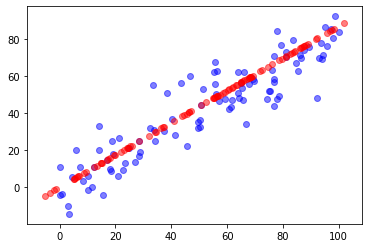

In [24]:
plt.scatter(X[:, 0], X[:, 1], color='b', alpha=0.5)
plt.scatter(X_restore[:, 0], X_restore[:, 1], color='r', alpha=0.5)
plt.show()

### scikit-learn中的PCA

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pca.components_    # 不是用梯度上升法求的，而是数学方法

array([[-0.75366744, -0.65725595]])

In [28]:
X_reduction = pca.transform(X)

In [29]:
X_reduction.shape

(100, 1)

In [30]:
X_restore = pca.inverse_transform(X_reduction)

In [32]:
X_restore.shape

(100, 2)

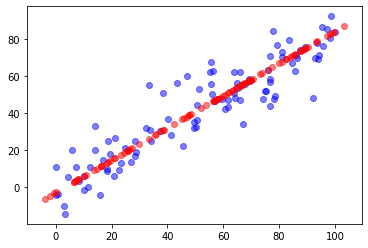

In [33]:
plt.scatter(X[:, 0], X[:, 1], color='b', alpha=0.5)
plt.scatter(X_restore[:, 0], X_restore[:, 1], color='r', alpha=0.5)
plt.show()

### 真实数据

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [35]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [39]:
X_train.shape

(1347, 64)

In [40]:
%%time

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

Wall time: 82.9 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
knn_clf.score(X_test, y_test)

0.9866666666666667

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [46]:
%%time

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

Wall time: 2.2 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
knn_clf.score(X_test_reduction, y_test)

0.6066666666666667

In [48]:
pca.explained_variance_ratio_

array([0.14566817, 0.13735469])

In [49]:
pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train)
pca.explained_variance_ratio_

array([1.45668166e-01, 1.37354688e-01, 1.17777287e-01, 8.49968861e-02,
       5.86018996e-02, 5.11542945e-02, 4.26605279e-02, 3.60119663e-02,
       3.41105814e-02, 3.05407804e-02, 2.42337671e-02, 2.28700570e-02,
       1.80304649e-02, 1.79346003e-02, 1.45798298e-02, 1.42044841e-02,
       1.29961033e-02, 1.26617002e-02, 1.01728635e-02, 9.09314698e-03,
       8.85220461e-03, 7.73828332e-03, 7.60516219e-03, 7.11864860e-03,
       6.85977267e-03, 5.76411920e-03, 5.71688020e-03, 5.08255707e-03,
       4.89020776e-03, 4.34888085e-03, 3.72917505e-03, 3.57755036e-03,
       3.26989470e-03, 3.14917937e-03, 3.09269839e-03, 2.87619649e-03,
       2.50362666e-03, 2.25417403e-03, 2.20030857e-03, 1.98028746e-03,
       1.88195578e-03, 1.52769283e-03, 1.42823692e-03, 1.38003340e-03,
       1.17572392e-03, 1.07377463e-03, 9.55152460e-04, 9.00017642e-04,
       5.79162563e-04, 3.82793717e-04, 2.38328586e-04, 8.40132221e-05,
       5.60545588e-05, 5.48538930e-05, 1.08077650e-05, 4.01354717e-06,
      

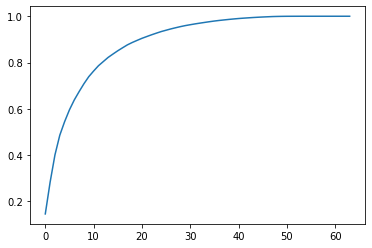

In [53]:
plt.plot([i for i in range(X_train.shape[1])],
    [np.sum(pca.explained_variance_ratio_[:i+1]) for  i in range(X_train.shape[1])])
plt.show()

In [54]:
pca = PCA(0.95)
pca.fit(X_train)
pca.explained_variance_ratio_

array([0.14566817, 0.13735469, 0.11777729, 0.08499689, 0.0586019 ,
       0.05115429, 0.04266053, 0.03601197, 0.03411058, 0.03054078,
       0.02423377, 0.02287006, 0.01803046, 0.0179346 , 0.01457983,
       0.01420448, 0.0129961 , 0.0126617 , 0.01017286, 0.00909315,
       0.0088522 , 0.00773828, 0.00760516, 0.00711865, 0.00685977,
       0.00576412, 0.00571688, 0.00508256])

In [56]:
pca.n_components_

28

In [57]:
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [58]:
%%time

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)

Wall time: 1.05 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
knn_clf.score(X_test_reduction, y_test)

0.98

In [60]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduction = pca.transform(X)

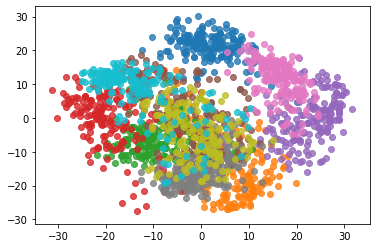

In [61]:
for i in range(10):
    plt.scatter(X_reduction[y==i, 0], X_reduction[y==i,1], alpha=0.8)
plt.show()